In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1249

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/1 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.752613	valid_0's recall_at4: 0.604687	valid_0's norm_gini: 0.900538


[100]	valid_0's amex_metric: 0.76443	valid_0's recall_at4: 0.622233	valid_0's norm_gini: 0.906626


[150]	valid_0's amex_metric: 0.770431	valid_0's recall_at4: 0.630438	valid_0's norm_gini: 0.910424


[200]	valid_0's amex_metric: 0.776018	valid_0's recall_at4: 0.637886	valid_0's norm_gini: 0.91415


[250]	valid_0's amex_metric: 0.781964	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.916617


[300]	valid_0's amex_metric: 0.784336	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.918206


[350]	valid_0's amex_metric: 0.786271	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.919425


[400]	valid_0's amex_metric: 0.788434	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.920383


[450]	valid_0's amex_metric: 0.789838	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.921088


[500]	valid_0's amex_metric: 0.791302	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.921618


[550]	valid_0's amex_metric: 0.792302	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.922061


[600]	valid_0's amex_metric: 0.791962	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922306


[650]	valid_0's amex_metric: 0.792471	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922652


[700]	valid_0's amex_metric: 0.7937	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.922922


[750]	valid_0's amex_metric: 0.793416	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.92311


[800]	valid_0's amex_metric: 0.793559	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923313


[850]	valid_0's amex_metric: 0.794299	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.923573


[900]	valid_0's amex_metric: 0.794929	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.923738


[950]	valid_0's amex_metric: 0.795051	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.923939


[1000]	valid_0's amex_metric: 0.795741	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.9241


[1050]	valid_0's amex_metric: 0.795386	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924273


[1100]	valid_0's amex_metric: 0.795562	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924457


[1150]	valid_0's amex_metric: 0.796668	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924565


[1200]	valid_0's amex_metric: 0.796943	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924696


[1250]	valid_0's amex_metric: 0.797154	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924823


[1300]	valid_0's amex_metric: 0.797184	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924882


[1350]	valid_0's amex_metric: 0.797216	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924946


[1400]	valid_0's amex_metric: 0.797106	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.92502


[1450]	valid_0's amex_metric: 0.797367	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925079


[1500]	valid_0's amex_metric: 0.797298	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925153


[1550]	valid_0's amex_metric: 0.797887	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925236


[1600]	valid_0's amex_metric: 0.797715	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925312


[1650]	valid_0's amex_metric: 0.797982	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925384


[1700]	valid_0's amex_metric: 0.797619	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925457


[1750]	valid_0's amex_metric: 0.797869	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925494


[1800]	valid_0's amex_metric: 0.798284	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925524


[1850]	valid_0's amex_metric: 0.798518	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925531


[1900]	valid_0's amex_metric: 0.798358	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925548


[1950]	valid_0's amex_metric: 0.79825	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925583


[2000]	valid_0's amex_metric: 0.798652	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.92563


[2050]	valid_0's amex_metric: 0.798676	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925636


[2100]	valid_0's amex_metric: 0.799095	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925674


[2150]	valid_0's amex_metric: 0.798658	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925685


[2200]	valid_0's amex_metric: 0.79841	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925734


[2250]	valid_0's amex_metric: 0.798338	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925759


[2300]	valid_0's amex_metric: 0.798591	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925761


[2350]	valid_0's amex_metric: 0.798607	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925793


[2400]	valid_0's amex_metric: 0.798886	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925804


[2450]	valid_0's amex_metric: 0.798642	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925821


[2500]	valid_0's amex_metric: 0.798655	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925847


[2550]	valid_0's amex_metric: 0.798895	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925863


[2600]	valid_0's amex_metric: 0.798972	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.92585


[2650]	valid_0's amex_metric: 0.798581	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925868


[2700]	valid_0's amex_metric: 0.798873	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925862


[2750]	valid_0's amex_metric: 0.79887	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925857


[2800]	valid_0's amex_metric: 0.798957	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925861


[2850]	valid_0's amex_metric: 0.798794	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925872


[2900]	valid_0's amex_metric: 0.798469	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925896


[2950]	valid_0's amex_metric: 0.799052	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925925


[3000]	valid_0's amex_metric: 0.798832	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925949


[3050]	valid_0's amex_metric: 0.799443	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.92595


[3100]	valid_0's amex_metric: 0.799717	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925952


[3150]	valid_0's amex_metric: 0.799725	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925966


[3200]	valid_0's amex_metric: 0.79976	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.925994


[3250]	valid_0's amex_metric: 0.799829	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926006


[3300]	valid_0's amex_metric: 0.799582	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926017


[3350]	valid_0's amex_metric: 0.799703	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926007


[3400]	valid_0's amex_metric: 0.799763	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926001


[3450]	valid_0's amex_metric: 0.7999	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926023


[3500]	valid_0's amex_metric: 0.799814	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926019


[3550]	valid_0's amex_metric: 0.799602	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926016


[3600]	valid_0's amex_metric: 0.799452	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926009


[3650]	valid_0's amex_metric: 0.799721	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926001


[3700]	valid_0's amex_metric: 0.799536	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926009


[3750]	valid_0's amex_metric: 0.799238	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926003


[3800]	valid_0's amex_metric: 0.799038	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926023


[3850]	valid_0's amex_metric: 0.79925	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926028


[3900]	valid_0's amex_metric: 0.799129	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926038


[3950]	valid_0's amex_metric: 0.799851	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926051


[4000]	valid_0's amex_metric: 0.799717	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926036


[4050]	valid_0's amex_metric: 0.799501	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926024


[4100]	valid_0's amex_metric: 0.799336	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926031


[4150]	valid_0's amex_metric: 0.799719	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926038


[4200]	valid_0's amex_metric: 0.799659	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926046


[4250]	valid_0's amex_metric: 0.799539	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926016


[4300]	valid_0's amex_metric: 0.799123	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926026


[4350]	valid_0's amex_metric: 0.799354	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926024


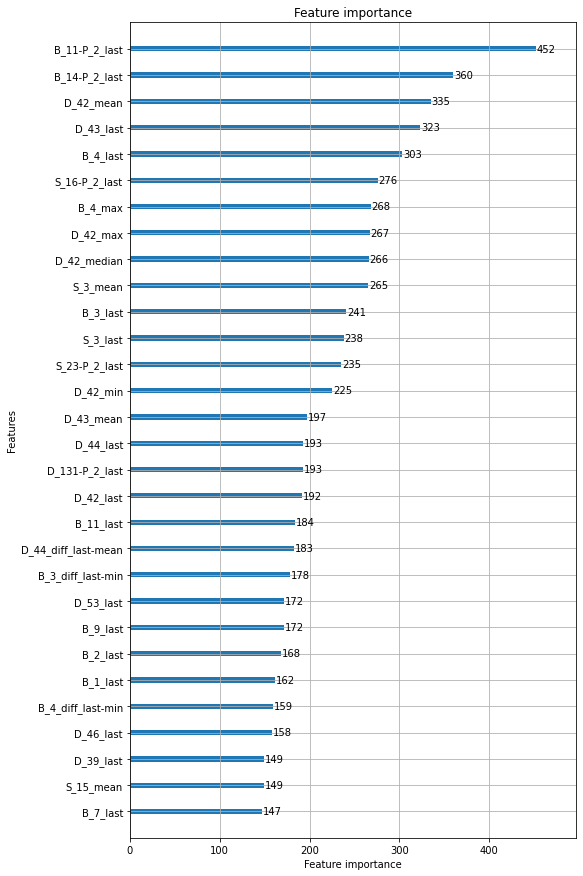

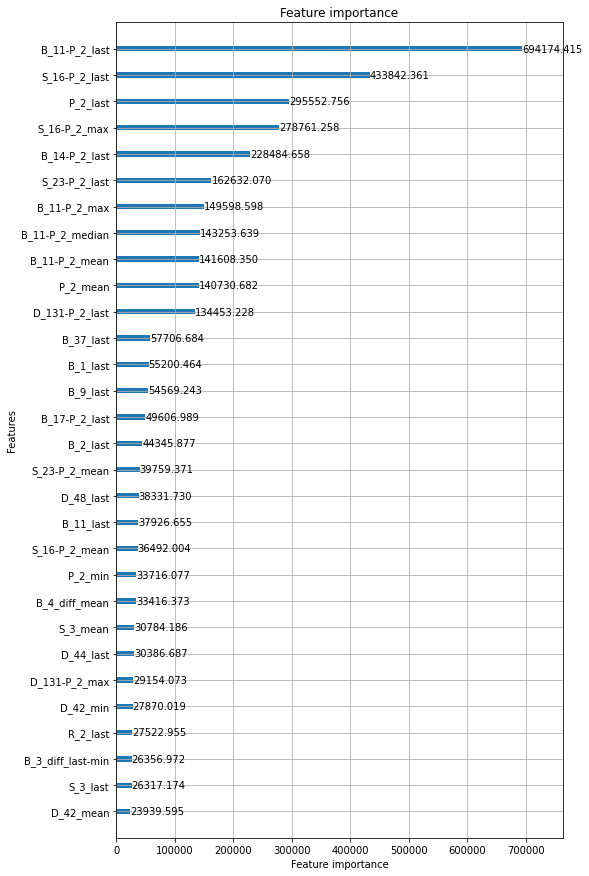

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.750299	valid_0's recall_at4: 0.60069	valid_0's norm_gini: 0.899908


[100]	valid_0's amex_metric: 0.76126	valid_0's recall_at4: 0.616805	valid_0's norm_gini: 0.905714


[150]	valid_0's amex_metric: 0.767476	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.909521


[200]	valid_0's amex_metric: 0.773947	valid_0's recall_at4: 0.63473	valid_0's norm_gini: 0.913164


[250]	valid_0's amex_metric: 0.778867	valid_0's recall_at4: 0.642304	valid_0's norm_gini: 0.91543


[300]	valid_0's amex_metric: 0.782158	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.91709


[350]	valid_0's amex_metric: 0.783212	valid_0's recall_at4: 0.648237	valid_0's norm_gini: 0.918186


[400]	valid_0's amex_metric: 0.785298	valid_0's recall_at4: 0.651477	valid_0's norm_gini: 0.919119


[450]	valid_0's amex_metric: 0.786227	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.919799


[500]	valid_0's amex_metric: 0.787652	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.920376


[550]	valid_0's amex_metric: 0.788046	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.920869


[600]	valid_0's amex_metric: 0.788441	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921155


[650]	valid_0's amex_metric: 0.789117	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.921497


[700]	valid_0's amex_metric: 0.789042	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.92181


[750]	valid_0's amex_metric: 0.790075	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.922067


[800]	valid_0's amex_metric: 0.789839	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922267


[850]	valid_0's amex_metric: 0.790391	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922531


[900]	valid_0's amex_metric: 0.791265	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.922722


[950]	valid_0's amex_metric: 0.791193	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.922958


[1000]	valid_0's amex_metric: 0.791899	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923191


[1050]	valid_0's amex_metric: 0.792561	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.92342


[1100]	valid_0's amex_metric: 0.793061	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923663


[1150]	valid_0's amex_metric: 0.79344	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923832


[1200]	valid_0's amex_metric: 0.793617	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923933


[1250]	valid_0's amex_metric: 0.79395	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924053


[1300]	valid_0's amex_metric: 0.794455	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924136


[1350]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924203


[1400]	valid_0's amex_metric: 0.79459	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.92428


[1450]	valid_0's amex_metric: 0.794419	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924359


[1500]	valid_0's amex_metric: 0.794893	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924465


[1550]	valid_0's amex_metric: 0.794679	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924543


[1600]	valid_0's amex_metric: 0.795141	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924625


[1650]	valid_0's amex_metric: 0.795199	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924699


[1700]	valid_0's amex_metric: 0.795241	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924741


[1750]	valid_0's amex_metric: 0.795869	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924819


[1800]	valid_0's amex_metric: 0.79543	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924909


[1850]	valid_0's amex_metric: 0.796033	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924979


[1900]	valid_0's amex_metric: 0.796299	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925006


[1950]	valid_0's amex_metric: 0.796579	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.925061


[2000]	valid_0's amex_metric: 0.796667	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.92511


[2050]	valid_0's amex_metric: 0.797128	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925148


[2100]	valid_0's amex_metric: 0.796908	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925172


[2150]	valid_0's amex_metric: 0.797306	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925252


[2200]	valid_0's amex_metric: 0.79736	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925277


[2250]	valid_0's amex_metric: 0.797834	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925299


[2300]	valid_0's amex_metric: 0.797828	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925329


[2350]	valid_0's amex_metric: 0.797378	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925355


[2400]	valid_0's amex_metric: 0.797321	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925367


[2450]	valid_0's amex_metric: 0.79728	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925369


[2500]	valid_0's amex_metric: 0.797091	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925411


[2550]	valid_0's amex_metric: 0.797428	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925413


[2600]	valid_0's amex_metric: 0.797351	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925427


[2650]	valid_0's amex_metric: 0.797926	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.92544


[2700]	valid_0's amex_metric: 0.797885	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925442


[2750]	valid_0's amex_metric: 0.797915	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.92546


[2800]	valid_0's amex_metric: 0.798088	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.92547


[2850]	valid_0's amex_metric: 0.797444	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925487


[2900]	valid_0's amex_metric: 0.798279	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925516


[2950]	valid_0's amex_metric: 0.798253	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925547


[3000]	valid_0's amex_metric: 0.797636	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925533


[3050]	valid_0's amex_metric: 0.79789	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925538


[3100]	valid_0's amex_metric: 0.798199	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925566


[3150]	valid_0's amex_metric: 0.798113	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925561


[3200]	valid_0's amex_metric: 0.798142	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925578


[3250]	valid_0's amex_metric: 0.79812	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925577


[3300]	valid_0's amex_metric: 0.797896	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925591


[3350]	valid_0's amex_metric: 0.798232	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925589


[3400]	valid_0's amex_metric: 0.798351	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925618


[3450]	valid_0's amex_metric: 0.798669	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925622


[3500]	valid_0's amex_metric: 0.798565	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925625


[3550]	valid_0's amex_metric: 0.798417	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925623


[3600]	valid_0's amex_metric: 0.798255	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925636


[3650]	valid_0's amex_metric: 0.798679	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925642


[3700]	valid_0's amex_metric: 0.798554	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925644


[3750]	valid_0's amex_metric: 0.798617	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925645


[3800]	valid_0's amex_metric: 0.798831	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925651


[3850]	valid_0's amex_metric: 0.798903	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925669


[3900]	valid_0's amex_metric: 0.798822	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925676


[3950]	valid_0's amex_metric: 0.798797	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925668


[4000]	valid_0's amex_metric: 0.798775	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925666


[4050]	valid_0's amex_metric: 0.798947	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925673


[4100]	valid_0's amex_metric: 0.799109	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925661


[4150]	valid_0's amex_metric: 0.799001	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925654


[4200]	valid_0's amex_metric: 0.79885	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925648


[4250]	valid_0's amex_metric: 0.798911	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925644


[4300]	valid_0's amex_metric: 0.799107	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925656


[4350]	valid_0's amex_metric: 0.798843	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925675


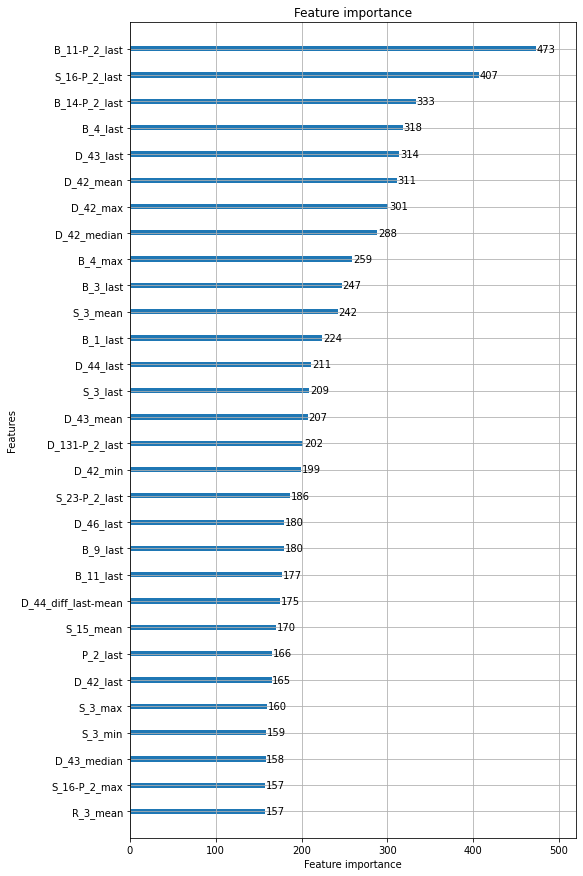

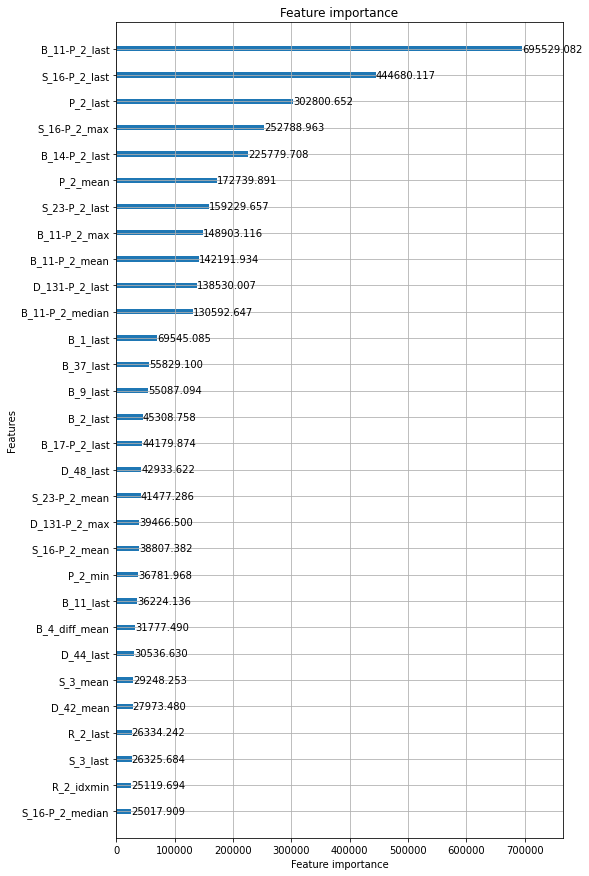

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.746324	valid_0's recall_at4: 0.593621	valid_0's norm_gini: 0.899026


[100]	valid_0's amex_metric: 0.756173	valid_0's recall_at4: 0.607633	valid_0's norm_gini: 0.904713


[150]	valid_0's amex_metric: 0.761444	valid_0's recall_at4: 0.614365	valid_0's norm_gini: 0.908524


[200]	valid_0's amex_metric: 0.768557	valid_0's recall_at4: 0.625137	valid_0's norm_gini: 0.911978


[250]	valid_0's amex_metric: 0.772678	valid_0's recall_at4: 0.631154	valid_0's norm_gini: 0.914203


[300]	valid_0's amex_metric: 0.776218	valid_0's recall_at4: 0.636666	valid_0's norm_gini: 0.915771


[350]	valid_0's amex_metric: 0.778624	valid_0's recall_at4: 0.640326	valid_0's norm_gini: 0.916922


[400]	valid_0's amex_metric: 0.781235	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.917894


[450]	valid_0's amex_metric: 0.782623	valid_0's recall_at4: 0.646638	valid_0's norm_gini: 0.918608


[500]	valid_0's amex_metric: 0.784122	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.919123


[550]	valid_0's amex_metric: 0.784653	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.919638


[600]	valid_0's amex_metric: 0.785309	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919941


[650]	valid_0's amex_metric: 0.785905	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.920291


[700]	valid_0's amex_metric: 0.786654	valid_0's recall_at4: 0.652739	valid_0's norm_gini: 0.920569


[750]	valid_0's amex_metric: 0.787514	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.920816


[800]	valid_0's amex_metric: 0.787955	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921026


[850]	valid_0's amex_metric: 0.788271	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.921319


[900]	valid_0's amex_metric: 0.788892	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.921469


[950]	valid_0's amex_metric: 0.788988	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.921702


[1000]	valid_0's amex_metric: 0.788821	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921915


[1050]	valid_0's amex_metric: 0.789346	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922123


[1100]	valid_0's amex_metric: 0.789653	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.922359


[1150]	valid_0's amex_metric: 0.790119	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.922492


[1200]	valid_0's amex_metric: 0.790101	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.922625


[1250]	valid_0's amex_metric: 0.790409	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.922736


[1300]	valid_0's amex_metric: 0.790957	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922821


[1350]	valid_0's amex_metric: 0.790826	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.922895


[1400]	valid_0's amex_metric: 0.791154	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.922962


[1450]	valid_0's amex_metric: 0.791075	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923058


[1500]	valid_0's amex_metric: 0.791558	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923139


[1550]	valid_0's amex_metric: 0.791459	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923236


[1600]	valid_0's amex_metric: 0.791402	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.92329


[1650]	valid_0's amex_metric: 0.790946	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923346


[1700]	valid_0's amex_metric: 0.791257	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.92338


[1750]	valid_0's amex_metric: 0.791562	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923442


[1800]	valid_0's amex_metric: 0.791838	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923489


[1850]	valid_0's amex_metric: 0.791683	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.923515


[1900]	valid_0's amex_metric: 0.79144	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923535


[1950]	valid_0's amex_metric: 0.791981	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923565


[2000]	valid_0's amex_metric: 0.791975	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923594


[2050]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923651


[2100]	valid_0's amex_metric: 0.792436	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.923676


[2150]	valid_0's amex_metric: 0.792028	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923701


[2200]	valid_0's amex_metric: 0.792347	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.92375


[2250]	valid_0's amex_metric: 0.792332	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923762


[2300]	valid_0's amex_metric: 0.792495	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.923793


[2350]	valid_0's amex_metric: 0.792292	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923809


[2400]	valid_0's amex_metric: 0.791982	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.923819


[2450]	valid_0's amex_metric: 0.792314	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923852


[2500]	valid_0's amex_metric: 0.792748	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923878


[2550]	valid_0's amex_metric: 0.792929	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.923903


[2600]	valid_0's amex_metric: 0.793145	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.923916


[2650]	valid_0's amex_metric: 0.793143	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.923952


[2700]	valid_0's amex_metric: 0.793129	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.92401


[2750]	valid_0's amex_metric: 0.793401	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924007


[2800]	valid_0's amex_metric: 0.793236	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924012


[2850]	valid_0's amex_metric: 0.793203	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924031


[2900]	valid_0's amex_metric: 0.793104	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924043


[2950]	valid_0's amex_metric: 0.793593	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924054


[3000]	valid_0's amex_metric: 0.79309	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924057


[3050]	valid_0's amex_metric: 0.792749	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.92409


[3100]	valid_0's amex_metric: 0.793152	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924098


[3150]	valid_0's amex_metric: 0.793012	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924112


[3200]	valid_0's amex_metric: 0.793285	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924111


[3250]	valid_0's amex_metric: 0.792858	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924099


[3300]	valid_0's amex_metric: 0.793458	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924079


[3350]	valid_0's amex_metric: 0.793395	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924079


[3400]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924085


[3450]	valid_0's amex_metric: 0.793275	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924091


[3500]	valid_0's amex_metric: 0.793317	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.92409


[3550]	valid_0's amex_metric: 0.792834	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924092


[3600]	valid_0's amex_metric: 0.793214	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924095


[3650]	valid_0's amex_metric: 0.79337	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924112


[3700]	valid_0's amex_metric: 0.792869	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924121


[3750]	valid_0's amex_metric: 0.793253	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924131


[3800]	valid_0's amex_metric: 0.793808	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924148


[3850]	valid_0's amex_metric: 0.793978	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.924151


[3900]	valid_0's amex_metric: 0.794013	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924136


[3950]	valid_0's amex_metric: 0.794259	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924124


[4000]	valid_0's amex_metric: 0.794212	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924114


[4050]	valid_0's amex_metric: 0.794313	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924106


[4100]	valid_0's amex_metric: 0.79415	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924115


[4150]	valid_0's amex_metric: 0.793934	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924104


[4200]	valid_0's amex_metric: 0.794144	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924104


[4250]	valid_0's amex_metric: 0.793766	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924106


[4300]	valid_0's amex_metric: 0.79416	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924094


[4350]	valid_0's amex_metric: 0.793998	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924107


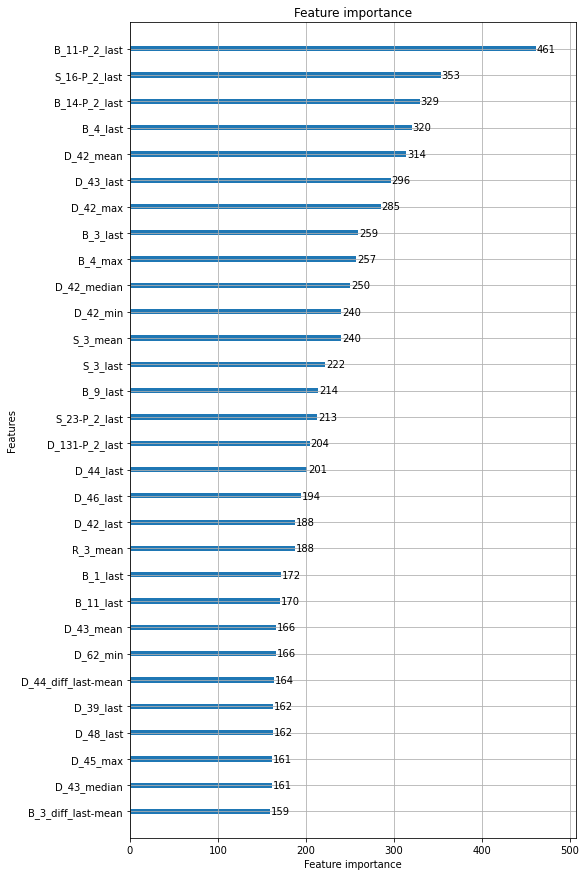

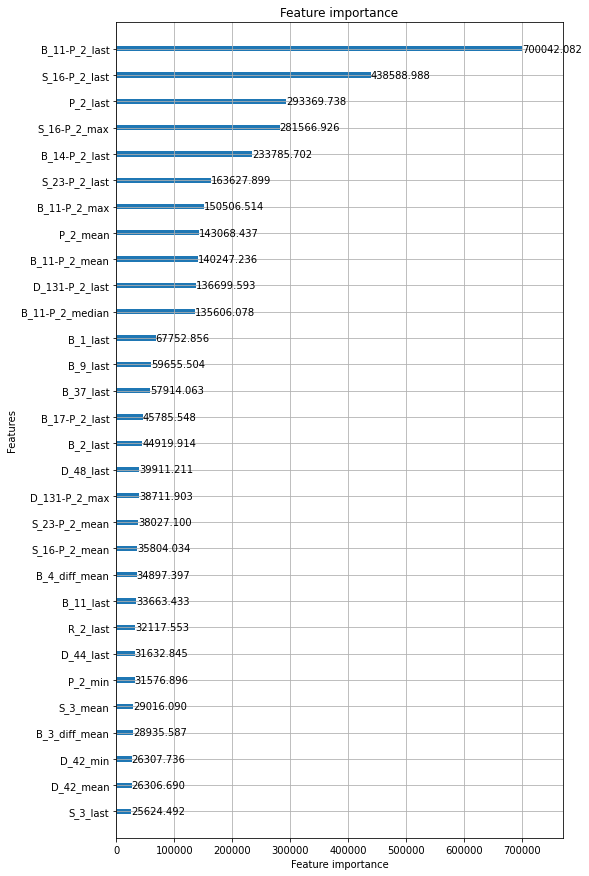

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.746312	valid_0's recall_at4: 0.594319	valid_0's norm_gini: 0.898305


[100]	valid_0's amex_metric: 0.7574	valid_0's recall_at4: 0.610562	valid_0's norm_gini: 0.904239


[150]	valid_0's amex_metric: 0.763355	valid_0's recall_at4: 0.618725	valid_0's norm_gini: 0.907984


[200]	valid_0's amex_metric: 0.770331	valid_0's recall_at4: 0.628824	valid_0's norm_gini: 0.911839


[250]	valid_0's amex_metric: 0.774259	valid_0's recall_at4: 0.634336	valid_0's norm_gini: 0.914182


[300]	valid_0's amex_metric: 0.776414	valid_0's recall_at4: 0.636987	valid_0's norm_gini: 0.915841


[350]	valid_0's amex_metric: 0.777937	valid_0's recall_at4: 0.638797	valid_0's norm_gini: 0.917077


[400]	valid_0's amex_metric: 0.779352	valid_0's recall_at4: 0.640648	valid_0's norm_gini: 0.918055


[450]	valid_0's amex_metric: 0.780404	valid_0's recall_at4: 0.641995	valid_0's norm_gini: 0.918813


[500]	valid_0's amex_metric: 0.781114	valid_0's recall_at4: 0.64292	valid_0's norm_gini: 0.919308


[550]	valid_0's amex_metric: 0.782642	valid_0's recall_at4: 0.645445	valid_0's norm_gini: 0.919839


[600]	valid_0's amex_metric: 0.783937	valid_0's recall_at4: 0.647717	valid_0's norm_gini: 0.920158


[650]	valid_0's amex_metric: 0.784357	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.920535


[700]	valid_0's amex_metric: 0.784911	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.920885


[750]	valid_0's amex_metric: 0.78566	valid_0's recall_at4: 0.650158	valid_0's norm_gini: 0.921161


[800]	valid_0's amex_metric: 0.786171	valid_0's recall_at4: 0.650957	valid_0's norm_gini: 0.921384


[850]	valid_0's amex_metric: 0.786161	valid_0's recall_at4: 0.650621	valid_0's norm_gini: 0.921701


[900]	valid_0's amex_metric: 0.786889	valid_0's recall_at4: 0.651883	valid_0's norm_gini: 0.921894


[950]	valid_0's amex_metric: 0.787409	valid_0's recall_at4: 0.652683	valid_0's norm_gini: 0.922135


[1000]	valid_0's amex_metric: 0.788024	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.922398


[1050]	valid_0's amex_metric: 0.788183	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.922631


[1100]	valid_0's amex_metric: 0.78906	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.922829


[1150]	valid_0's amex_metric: 0.789885	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.923007


[1200]	valid_0's amex_metric: 0.789441	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923127


[1250]	valid_0's amex_metric: 0.789802	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.923261


[1300]	valid_0's amex_metric: 0.790103	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.923359


[1350]	valid_0's amex_metric: 0.79014	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.92339


[1400]	valid_0's amex_metric: 0.790537	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.923511


[1450]	valid_0's amex_metric: 0.790368	valid_0's recall_at4: 0.657143	valid_0's norm_gini: 0.923593


[1500]	valid_0's amex_metric: 0.790524	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.923695


[1550]	valid_0's amex_metric: 0.791038	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.923796


[1600]	valid_0's amex_metric: 0.79056	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.923851


[1650]	valid_0's amex_metric: 0.790826	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.923921


[1700]	valid_0's amex_metric: 0.791016	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923963


[1750]	valid_0's amex_metric: 0.791273	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924015


[1800]	valid_0's amex_metric: 0.791464	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.92406


[1850]	valid_0's amex_metric: 0.791272	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924097


[1900]	valid_0's amex_metric: 0.791814	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.924129


[1950]	valid_0's amex_metric: 0.791605	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.924174


[2000]	valid_0's amex_metric: 0.791792	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.92421


[2050]	valid_0's amex_metric: 0.791634	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.924231


[2100]	valid_0's amex_metric: 0.791395	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924258


[2150]	valid_0's amex_metric: 0.791719	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924317


[2200]	valid_0's amex_metric: 0.791623	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924336


[2250]	valid_0's amex_metric: 0.791547	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924351


[2300]	valid_0's amex_metric: 0.791285	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.924374


[2350]	valid_0's amex_metric: 0.791822	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924398


[2400]	valid_0's amex_metric: 0.791977	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924413


[2450]	valid_0's amex_metric: 0.79154	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.924464


[2500]	valid_0's amex_metric: 0.791806	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924492


[2550]	valid_0's amex_metric: 0.792528	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.924505


[2600]	valid_0's amex_metric: 0.792086	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924546


[2650]	valid_0's amex_metric: 0.792532	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924555


[2700]	valid_0's amex_metric: 0.792058	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924575


[2750]	valid_0's amex_metric: 0.792327	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924565


[2800]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924571


[2850]	valid_0's amex_metric: 0.792283	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924605


[2900]	valid_0's amex_metric: 0.792375	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924619


[2950]	valid_0's amex_metric: 0.792443	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924628


[3000]	valid_0's amex_metric: 0.792305	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924648


[3050]	valid_0's amex_metric: 0.792057	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.924656


[3100]	valid_0's amex_metric: 0.792675	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924672


[3150]	valid_0's amex_metric: 0.792724	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924645


[3200]	valid_0's amex_metric: 0.792428	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.924642


[3250]	valid_0's amex_metric: 0.793053	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924629


[3300]	valid_0's amex_metric: 0.793077	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.924634


[3350]	valid_0's amex_metric: 0.792527	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924629


[3400]	valid_0's amex_metric: 0.792591	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.92463


[3450]	valid_0's amex_metric: 0.792517	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924651


[3500]	valid_0's amex_metric: 0.792515	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924648


[3550]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924691


[3600]	valid_0's amex_metric: 0.79318	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924714


[3650]	valid_0's amex_metric: 0.79317	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924737


[3700]	valid_0's amex_metric: 0.792769	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924735


[3750]	valid_0's amex_metric: 0.793068	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924742


[3800]	valid_0's amex_metric: 0.793084	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924733


[3850]	valid_0's amex_metric: 0.792713	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924706


[3900]	valid_0's amex_metric: 0.792424	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924718


[3950]	valid_0's amex_metric: 0.792525	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.92471


[4000]	valid_0's amex_metric: 0.792693	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924708


[4050]	valid_0's amex_metric: 0.792733	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924705


[4100]	valid_0's amex_metric: 0.792325	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924688


[4150]	valid_0's amex_metric: 0.792583	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924698


[4200]	valid_0's amex_metric: 0.792699	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924679


[4250]	valid_0's amex_metric: 0.792696	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924673


[4300]	valid_0's amex_metric: 0.792518	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924653


[4350]	valid_0's amex_metric: 0.792315	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924626


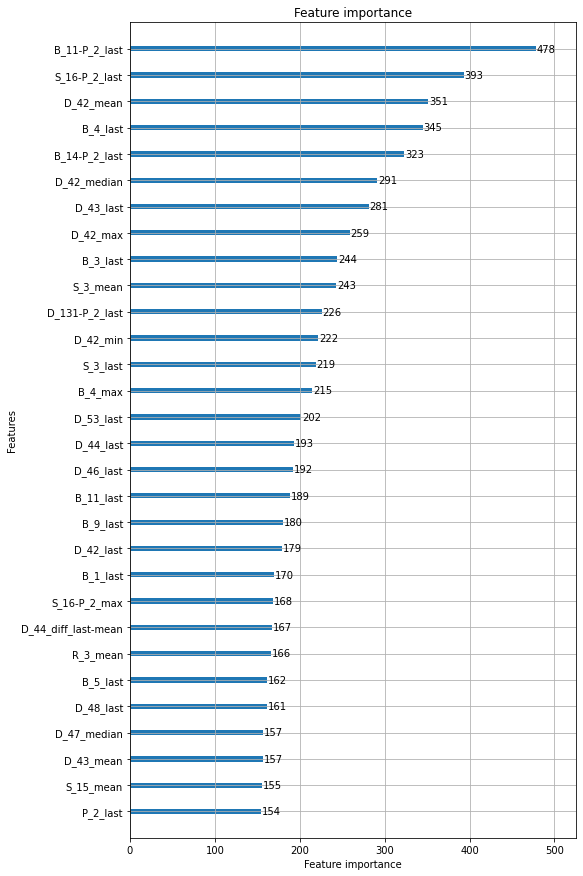

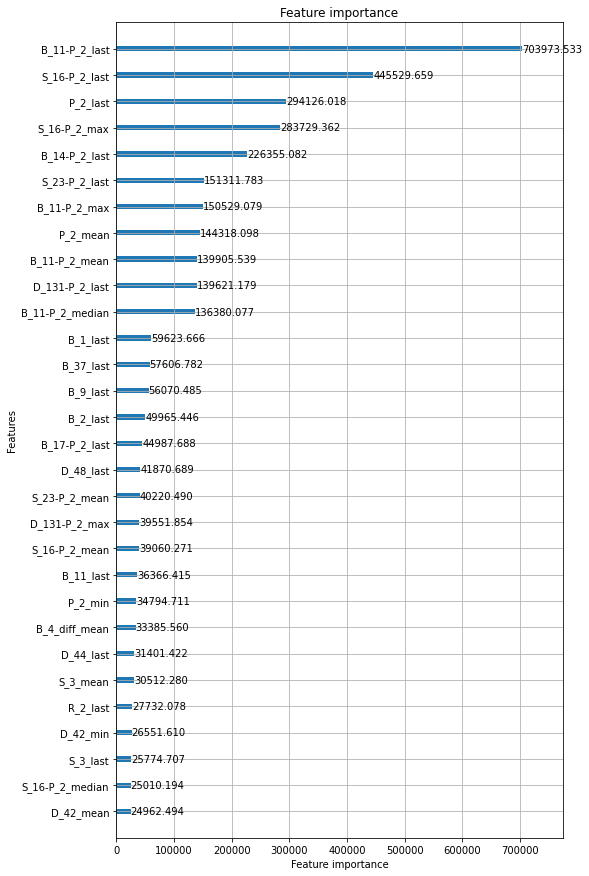

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.753845	valid_0's recall_at4: 0.606101	valid_0's norm_gini: 0.901589


[100]	valid_0's amex_metric: 0.766139	valid_0's recall_at4: 0.624237	valid_0's norm_gini: 0.908041


[150]	valid_0's amex_metric: 0.772472	valid_0's recall_at4: 0.6332	valid_0's norm_gini: 0.911745


[200]	valid_0's amex_metric: 0.777311	valid_0's recall_at4: 0.639091	valid_0's norm_gini: 0.915531


[250]	valid_0's amex_metric: 0.781369	valid_0's recall_at4: 0.644898	valid_0's norm_gini: 0.917841


[300]	valid_0's amex_metric: 0.785031	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.919357


[350]	valid_0's amex_metric: 0.786475	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920562


[400]	valid_0's amex_metric: 0.788006	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.921562


[450]	valid_0's amex_metric: 0.790041	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.922309


[500]	valid_0's amex_metric: 0.791392	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.922821


[550]	valid_0's amex_metric: 0.792183	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.92331


[600]	valid_0's amex_metric: 0.793168	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.92364


[650]	valid_0's amex_metric: 0.794142	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.923987


[700]	valid_0's amex_metric: 0.794674	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924337


[750]	valid_0's amex_metric: 0.795842	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.92461


[800]	valid_0's amex_metric: 0.796174	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924812


[850]	valid_0's amex_metric: 0.796622	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.925034


[900]	valid_0's amex_metric: 0.796824	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.925228


[950]	valid_0's amex_metric: 0.79793	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925461


[1000]	valid_0's amex_metric: 0.798566	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.925683


[1050]	valid_0's amex_metric: 0.798992	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.925904


[1100]	valid_0's amex_metric: 0.799447	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.926097


[1150]	valid_0's amex_metric: 0.800102	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.92623


[1200]	valid_0's amex_metric: 0.800016	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926352


[1250]	valid_0's amex_metric: 0.799821	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926467


[1300]	valid_0's amex_metric: 0.799975	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926523


[1350]	valid_0's amex_metric: 0.799913	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926567


[1400]	valid_0's amex_metric: 0.800474	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.92668


[1450]	valid_0's amex_metric: 0.800494	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.92672


[1500]	valid_0's amex_metric: 0.800671	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.926778


[1550]	valid_0's amex_metric: 0.800811	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926848


[1600]	valid_0's amex_metric: 0.80128	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.926902


[1650]	valid_0's amex_metric: 0.801565	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.926967


[1700]	valid_0's amex_metric: 0.801477	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927003


[1750]	valid_0's amex_metric: 0.8018	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927059


[1800]	valid_0's amex_metric: 0.801994	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.92711


[1850]	valid_0's amex_metric: 0.801865	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927148


[1900]	valid_0's amex_metric: 0.801751	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927172


[1950]	valid_0's amex_metric: 0.80203	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.927225


[2000]	valid_0's amex_metric: 0.802349	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927274


[2050]	valid_0's amex_metric: 0.802475	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927315


[2100]	valid_0's amex_metric: 0.802086	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.927336


[2150]	valid_0's amex_metric: 0.802646	valid_0's recall_at4: 0.67793	valid_0's norm_gini: 0.927363


[2200]	valid_0's amex_metric: 0.802134	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.92739


[2250]	valid_0's amex_metric: 0.802824	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927423


[2300]	valid_0's amex_metric: 0.802495	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.92744


[2350]	valid_0's amex_metric: 0.802865	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.927465


[2400]	valid_0's amex_metric: 0.802728	valid_0's recall_at4: 0.67793	valid_0's norm_gini: 0.927527


[2450]	valid_0's amex_metric: 0.802334	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.927537


[2500]	valid_0's amex_metric: 0.802584	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927532


[2550]	valid_0's amex_metric: 0.802629	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927539


[2600]	valid_0's amex_metric: 0.802804	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927552


[2650]	valid_0's amex_metric: 0.802679	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927555


[2700]	valid_0's amex_metric: 0.802951	valid_0's recall_at4: 0.678351	valid_0's norm_gini: 0.927551


[2750]	valid_0's amex_metric: 0.802641	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927562


[2800]	valid_0's amex_metric: 0.80283	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.927561


[2850]	valid_0's amex_metric: 0.802629	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.92758


[2900]	valid_0's amex_metric: 0.802608	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.92758


[2950]	valid_0's amex_metric: 0.802881	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.927579


[3000]	valid_0's amex_metric: 0.803036	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927596


[3050]	valid_0's amex_metric: 0.802783	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927595


[3100]	valid_0's amex_metric: 0.802845	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.927592


[3150]	valid_0's amex_metric: 0.802576	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.927601


[3200]	valid_0's amex_metric: 0.80236	valid_0's recall_at4: 0.677088	valid_0's norm_gini: 0.927632


[3250]	valid_0's amex_metric: 0.802444	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.927631


[3300]	valid_0's amex_metric: 0.802262	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927647


[3350]	valid_0's amex_metric: 0.802348	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927651


[3400]	valid_0's amex_metric: 0.802327	valid_0's recall_at4: 0.677004	valid_0's norm_gini: 0.927651


[3450]	valid_0's amex_metric: 0.802826	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927681


[3500]	valid_0's amex_metric: 0.802958	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927692


[3550]	valid_0's amex_metric: 0.802745	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927687


[3600]	valid_0's amex_metric: 0.802696	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927715


[3650]	valid_0's amex_metric: 0.802684	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927732


[3700]	valid_0's amex_metric: 0.802547	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.927753


[3750]	valid_0's amex_metric: 0.802574	valid_0's recall_at4: 0.677383	valid_0's norm_gini: 0.927766


[3800]	valid_0's amex_metric: 0.802768	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927775


[3850]	valid_0's amex_metric: 0.802873	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927775


[3900]	valid_0's amex_metric: 0.803186	valid_0's recall_at4: 0.678603	valid_0's norm_gini: 0.927768


[3950]	valid_0's amex_metric: 0.80296	valid_0's recall_at4: 0.67814	valid_0's norm_gini: 0.927779


[4000]	valid_0's amex_metric: 0.802918	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927779


[4050]	valid_0's amex_metric: 0.802944	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.92779


[4100]	valid_0's amex_metric: 0.802737	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927798


[4150]	valid_0's amex_metric: 0.802932	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927807


[4200]	valid_0's amex_metric: 0.803016	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927807


[4250]	valid_0's amex_metric: 0.803017	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927809


[4300]	valid_0's amex_metric: 0.803385	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.92783


[4350]	valid_0's amex_metric: 0.803611	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.927821


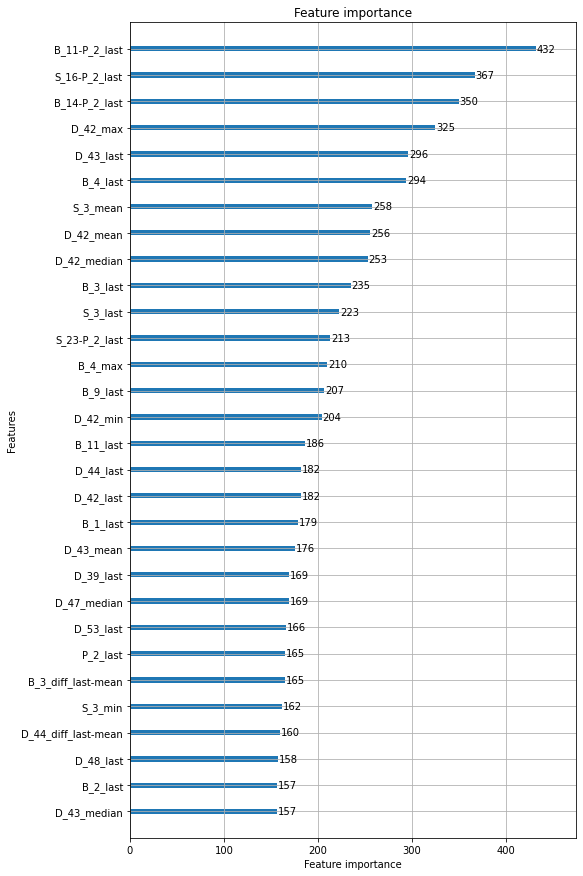

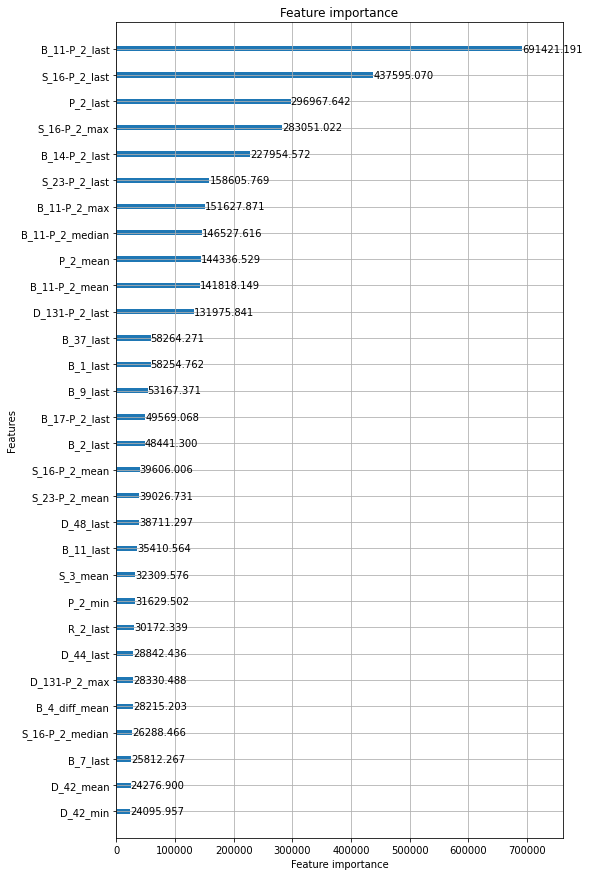

Training time: 35.83278966347377 min.


OOF recall_at4: 0.6692109603797085


OOF normalized_gini: 0.9255211965551022


OOF competition metric: 0.7973660784674054


CPU times: user 12h 51min 42s, sys: 1min 1s, total: 12h 52min 43s
Wall time: 36min 3s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.669211,0.925521,0.797366



mean:


recall_at4    0.669211
gini          0.925521
metric        0.797366
dtype: float64


std:


recall_at4   NaN
gini         NaN
metric       NaN
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 36min 27s, sys: 38 s, total: 37min 5s
Wall time: 2min 18s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.71 s, sys: 1.59 s, total: 5.3 s
Wall time: 5.43 s


***